In [4]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_Pointnet"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 828, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 828 (delta 72), reused 97 (delta 43), pack-reused 674 (from 1)
Receiving objects: 100% (828/828), 12.55 MiB | 38.24 MiB/s, done.
Resolving deltas: 100% (454/454), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [5]:
sys.path.insert(0,"/kaggle/working/6D_pose")

In [ ]:
# AVOID RUNNING IN KAGGLE!

%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [6]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive2 instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [ ]:
%mv Linemod_preprocessed working/

In [7]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed_small"
# dataset_root = "/content/Linemod_preprocessed"
# dataset_root = "/kaggle/working/Linemod_preprocessed"
dataset_root = "/kaggle/input/line-mode/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/input/line-mode/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%mv Linemod_preprocessed ./working

In [8]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00


In [9]:
import sys

sys.path.append('../..')

In [10]:
from src.pose_pointnet.dataset import PointNetLineModDataset

train_dataset = PointNetLineModDataset(
    root_dir=dataset_root,
    split="train",
    augment=True
)

test_dataset = PointNetLineModDataset(
    root_dir=dataset_root,
    split="test",
    augment=False
)


✅ LineModConfig initialized: /kaggle/input/line-mode/Linemod_preprocessed
✅ Loaded PointNetLineModDataset
   Split: train (Ratio: 0.8)
   Num Points: 1024
   Total samples: 12634
✅ Loaded PointNetLineModDataset
   Split: test (Ratio: 0.8)
   Num Points: 1024
   Total samples: 3166


In [15]:
import torch
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: Tensor of shape {value.shape} and dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)} with value {value}")

Sample keys: dict_keys(['points', 'centroid', 'rotation', 't_residual', 'gt_translation', 'object_id', 'class_idx', 'img_id', 'cam_K'])
  points: Tensor of shape torch.Size([3, 1024]) and dtype torch.float32
  centroid: Tensor of shape torch.Size([3]) and dtype torch.float32
  rotation: Tensor of shape torch.Size([4]) and dtype torch.float32
  t_residual: Tensor of shape torch.Size([3]) and dtype torch.float32
  gt_translation: Tensor of shape torch.Size([3]) and dtype torch.float32
  object_id: <class 'int'> with value 1
  class_idx: <class 'str'> with value ape
  img_id: <class 'int'> with value 987
  cam_K: Tensor of shape torch.Size([3, 3]) and dtype torch.float32


In [16]:
import torch

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
from utils.linemod_config import get_linemod_config
import numpy as np
import torch


linemod_config = get_linemod_config(dataset_root)

all_model_points = []
NUM_POINTS = 1000  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx


In [19]:
all_model_points.shape

torch.Size([13, 1000, 3])

In [21]:
from src.pose_pointnet.loss import MultiObjectPointMatchingLoss
import torch.nn as nn
from src.pose_pointnet.model import PointNetPoseModel
from torch.optim import Adam, AdamW

model = PointNetPoseModel()

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = AdamW(
    model.parameters(), 
    lr=0.001, 
    betas=(0.9, 0.999), 
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=250,      # Imposta il numero delle tue epoche totali qui!
    eta_min=1e-5
)

🔥 Using 2 GPU!


In [22]:
def set_bn_momentum_default(curr_epoch, total_epochs, model):
    """
    Decade il momentum della Batch Norm da 0.1 a 0.01 seguendo una curva a step o coseno.
    In PyTorch il default momentum è 0.1.
    """
    # Formula originale PointNet: decade del 50% ogni tot step
    # Qui usiamo una versione coseno più moderna e fluida
    
    # Calcola il momentum target: parte da 0.1 e scende a 0.01
    start_mom = 0.1
    end_mom = 0.01
    
    # Interpolazione semplice basata sull'epoca
    momentum = end_mom + (start_mom - end_mom) * (1 - (curr_epoch / total_epochs))
    
    # Applica a tutti i layer di Batch Norm nel modello
    for m in model.modules():
        if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            m.momentum = momentum

In [23]:
from torch.utils.data import DataLoader

batch_size = 128  #double GPU

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          persistent_workers=True,
                          drop_last=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         pin_memory=True,
                         persistent_workers=True,
                         num_workers=4)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoupledPoseLoss(nn.Module):
    def __init__(self, rot_weight=1.0, trans_weight=1.0):
        super().__init__()
        self.rot_weight = rot_weight
        self.trans_weight = trans_weight
        # Log per vedere i valori separati
        self.last_rot_loss = 0.0
        self.last_trans_loss = 0.0

    def forward(self, pred_q, pred_t, gt_q, gt_t):
        """
        pred_t e gt_t devono essere entrambi assoluti (o entrambi residui).
        """
        
        # --- 1. LOSS TRASLAZIONE (MSE o L1) ---
        # MSE è più aggressivo sugli errori grandi, L1 è più stabile
        loss_trans = F.mse_loss(pred_t, gt_t)
        
        # --- 2. LOSS ROTAZIONE (Cosine Distance) ---
        # I quaternioni q e -q rappresentano la stessa rotazione.
        # Quindi vogliamo massimizzare il valore assoluto del prodotto scalare.
        # Loss = 1 - |<q1, q2>|
        dot_product = torch.sum(pred_q * gt_q, dim=1)
        loss_rot = 1.0 - torch.mean(torch.abs(dot_product))
        
        # --- 3. SOMMA PESATA ---
        total_loss = (self.trans_weight * loss_trans) + (self.rot_weight * loss_rot)
        
        # Salviamo i valori per stamparli (opzionale)
        self.last_trans_loss = loss_trans.item()
        self.last_rot_loss = loss_rot.item()
        
        return total_loss

In [25]:
def compute_rotation_error(pred_q, gt_q):
    """
    Calcola l'errore angolare medio in GRADI tra due batch di quaternioni.
    """
    # Prodotto scalare tra i quaternioni (q1 * q2)
    # clamp serve per evitare errori numerici se il valore supera 1.0 per pochissimo
    dot_product = torch.sum(pred_q * gt_q, dim=1)
    dot_product = torch.clamp(torch.abs(dot_product), max=1.0) 
    
    # Formula: 2 * arccos(|dot|)
    theta_rad = 2 * torch.acos(dot_product)
    theta_deg = torch.rad2deg(theta_rad)
    
    return theta_deg.mean().item()

In [26]:
from tqdm import tqdm
import os
import torch
from datetime import datetime

# ==========================================
# 0. SETUP AND CONFIGURATION
# ==========================================
num_epochs = 250  # PointNet converges relatively fast
best_test_loss = float('inf')
batch_size = 32  # Adjust based on your GPU VRAM

# Setup checkpoint directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'/kaggle/working/POINTNET_{timestamp}'
# checkpoint_dir = f'./POINTNET_{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)

# Trackers for plotting
train_losses = []
test_losses = []

print(f"🚀 Starting PointNet Training on {device}")
print(f"📁 Checkpoints will be saved to: {checkpoint_dir}")
print(f"🗺️  Object ID Mapping created for {len(obj_id_to_idx)} objects.")

# ==========================================
# 1. TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    set_bn_momentum_default(epoch, num_epochs, model)
    
    model.train()
    epoch_loss = 0.0

    # Initialize progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    
    for batch in train_pbar:
        # Move data to GPU
        # PointNet input: (Batch, 3, Num_Points)
        points = batch['points'].to(device)  
        
        # Auxiliary data for reconstruction and loss
        centroids = batch['centroid'].to(device)       # (B, 3)
        gt_rotations = batch['rotation'].to(device)    # (B, 4)
        gt_t_absolute = batch['gt_translation'].to(device) # (B, 3) - Absolute target
        
        # Handle Object IDs for Loss Indexing
        raw_obj_ids = batch['object_id'].tolist()
        # Map raw IDs (e.g., 15) to buffer indices (e.g., 12)
        target_indices = torch.tensor(
            [obj_id_to_idx[oid] for oid in raw_obj_ids], 
            dtype=torch.long, device=device
        )

        # --- FORWARD PASS ---
        optimizer.zero_grad()
        
        # The network predicts: 
        # 1. Quaternion (pred_q)
        # 2. Residual Translation relative to centroid (pred_t_res)
        pred_q, pred_t_res = model(points)

        # --- RECONSTRUCTION ---
        # Reconstruct absolute translation for the ADD Loss
        # Absolute_Pos = Centroid + Residual
        pred_t_abs = centroids + pred_t_res

        # --- LOSS CALCULATION ---
        # Using MultiObjectPointMatchingLoss (ADD metric)
        loss_add = criterion(
            pred_q=pred_q, 
            pred_t=pred_t_abs,   # Pass the reconstructed absolute translation
            gt_q=gt_rotations, 
            gt_t=gt_t_absolute, 
            class_indices=target_indices
        )

        # pure loss on quaternions
        # dot = torch.sum(pred_q * gt_rotations, dim=1)
        # loss_rot_pure = 1.0 - torch.mean(torch.abs(dot))
        
        # Final Hybrid Loss
        loss = loss_add # + (2.0 * loss_rot_pure)
        
        loss.backward()
        optimizer.step()

        # Update stats
        epoch_loss += loss.item()
        train_pbar.set_postfix({'ADD Loss (m)': f"{loss.item():.4f}"})

    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    scheduler.step()

    # ==========================================
    # 2. VALIDATION LOOP
    # ==========================================
    model.eval()
    test_loss = 0.0
    val_pbar = tqdm(test_loader, desc="Validating")
    
    with torch.no_grad():
        for batch in val_pbar:
            # Move data to GPU
            points = batch['points'].to(device)
            centroids = batch['centroid'].to(device)
            gt_rotations = batch['rotation'].to(device)
            gt_t_absolute = batch['gt_translation'].to(device)
            
            # Map IDs
            raw_obj_ids = batch['object_id'].tolist()
            target_indices = torch.tensor(
                [obj_id_to_idx[oid] for oid in raw_obj_ids], 
                dtype=torch.long, device=device
            )

            # Forward
            pred_q, pred_t_res = model(points)

            # Reconstruction
            pred_t_abs = centroids + pred_t_res

            # Loss
            loss = criterion(
                pred_q=pred_q, 
                pred_t=pred_t_abs, 
                gt_q=gt_rotations, 
                gt_t=gt_t_absolute, 
                class_indices=target_indices
            )

            rot_err = compute_rotation_error(pred_q, gt_rotations)
            val_pbar.set_postfix({
                'Val Loss': f"{loss.item():.4f}", 
                'Rot Err (deg)': f"{rot_err:.1f}°"  # <--- ECCOLO!
            })
            
            test_loss += loss.item()
            val_pbar.set_postfix({'Val Loss': f"{loss.item():.4f}"})

    # Calculate average validation loss
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} m | Val Loss: {avg_test_loss:.4f} m")

    # ==========================================
    # 3. CHECKPOINT SAVING
    # ==========================================
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        
        # Handle DataParallel state_dict if necessary
        model_state = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_test_loss,
            'config': { 
                'num_points': 1024, # Useful for inference
                'obj_map': obj_id_to_idx
            }
        }, checkpoint_path)
        print(f"✅ New Record! Model saved with Loss: {best_test_loss:.4f} m")
    else:
        print(f"⏳ No improvement (Best: {best_test_loss:.4f} m)")
    
    print("-" * 60)

🚀 Starting PointNet Training on cuda
📁 Checkpoints will be saved to: /kaggle/working/POINTNET_20251222_165425
🗺️  Object ID Mapping created for 16 objects.


Validating: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, Val Loss=0.0677]                      


📊 Epoch [1/250] | Train Loss: 0.2113 m | Val Loss: 0.0771 m
✅ New Record! Model saved with Loss: 0.0771 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0617]                     


📊 Epoch [2/250] | Train Loss: 0.1087 m | Val Loss: 0.0639 m
✅ New Record! Model saved with Loss: 0.0639 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0600]                     


📊 Epoch [3/250] | Train Loss: 0.0756 m | Val Loss: 0.0543 m
✅ New Record! Model saved with Loss: 0.0543 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0564]                      


📊 Epoch [4/250] | Train Loss: 0.0593 m | Val Loss: 0.0515 m
✅ New Record! Model saved with Loss: 0.0515 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.14it/s, Val Loss=0.0483]                      


📊 Epoch [5/250] | Train Loss: 0.0516 m | Val Loss: 0.0450 m
✅ New Record! Model saved with Loss: 0.0450 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.29it/s, Val Loss=0.0479]                      


📊 Epoch [6/250] | Train Loss: 0.0464 m | Val Loss: 0.0448 m
✅ New Record! Model saved with Loss: 0.0448 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0506]                      


📊 Epoch [7/250] | Train Loss: 0.0452 m | Val Loss: 0.0470 m
⏳ No improvement (Best: 0.0448 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0440]                      


📊 Epoch [8/250] | Train Loss: 0.0439 m | Val Loss: 0.0438 m
✅ New Record! Model saved with Loss: 0.0438 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.56it/s, Val Loss=0.0406]                      


📊 Epoch [9/250] | Train Loss: 0.0417 m | Val Loss: 0.0448 m
⏳ No improvement (Best: 0.0438 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, Val Loss=0.0364]                      


📊 Epoch [10/250] | Train Loss: 0.0407 m | Val Loss: 0.0408 m
✅ New Record! Model saved with Loss: 0.0408 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0385]                      


📊 Epoch [11/250] | Train Loss: 0.0389 m | Val Loss: 0.0390 m
✅ New Record! Model saved with Loss: 0.0390 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.36it/s, Val Loss=0.0471]                     


📊 Epoch [12/250] | Train Loss: 0.0380 m | Val Loss: 0.0418 m
⏳ No improvement (Best: 0.0390 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s, Val Loss=0.0305]                      


📊 Epoch [13/250] | Train Loss: 0.0381 m | Val Loss: 0.0346 m
✅ New Record! Model saved with Loss: 0.0346 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.42it/s, Val Loss=0.0306]                     


📊 Epoch [14/250] | Train Loss: 0.0366 m | Val Loss: 0.0364 m
⏳ No improvement (Best: 0.0346 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, Val Loss=0.0306]                     


📊 Epoch [15/250] | Train Loss: 0.0349 m | Val Loss: 0.0372 m
⏳ No improvement (Best: 0.0346 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0253]                     


📊 Epoch [16/250] | Train Loss: 0.0353 m | Val Loss: 0.0310 m
✅ New Record! Model saved with Loss: 0.0310 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0348]                     


📊 Epoch [17/250] | Train Loss: 0.0338 m | Val Loss: 0.0383 m
⏳ No improvement (Best: 0.0310 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0255]                     


📊 Epoch [18/250] | Train Loss: 0.0320 m | Val Loss: 0.0299 m
✅ New Record! Model saved with Loss: 0.0299 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0270]                     


📊 Epoch [19/250] | Train Loss: 0.0324 m | Val Loss: 0.0329 m
⏳ No improvement (Best: 0.0299 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0316]                      


📊 Epoch [20/250] | Train Loss: 0.0326 m | Val Loss: 0.0334 m
⏳ No improvement (Best: 0.0299 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0373]                      


📊 Epoch [21/250] | Train Loss: 0.0310 m | Val Loss: 0.0393 m
⏳ No improvement (Best: 0.0299 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0311]                     


📊 Epoch [22/250] | Train Loss: 0.0312 m | Val Loss: 0.0323 m
⏳ No improvement (Best: 0.0299 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, Val Loss=0.0398]                     


📊 Epoch [23/250] | Train Loss: 0.0304 m | Val Loss: 0.0385 m
⏳ No improvement (Best: 0.0299 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0247]                     


📊 Epoch [24/250] | Train Loss: 0.0300 m | Val Loss: 0.0281 m
✅ New Record! Model saved with Loss: 0.0281 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0225]                     


📊 Epoch [25/250] | Train Loss: 0.0288 m | Val Loss: 0.0281 m
⏳ No improvement (Best: 0.0281 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, Val Loss=0.0310]                     


📊 Epoch [26/250] | Train Loss: 0.0304 m | Val Loss: 0.0321 m
⏳ No improvement (Best: 0.0281 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s, Val Loss=0.0242]                      


📊 Epoch [27/250] | Train Loss: 0.0287 m | Val Loss: 0.0284 m
⏳ No improvement (Best: 0.0281 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0305]                     


📊 Epoch [28/250] | Train Loss: 0.0287 m | Val Loss: 0.0295 m
⏳ No improvement (Best: 0.0281 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, Val Loss=0.0235]                      


📊 Epoch [29/250] | Train Loss: 0.0280 m | Val Loss: 0.0266 m
✅ New Record! Model saved with Loss: 0.0266 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, Val Loss=0.0220]                     


📊 Epoch [30/250] | Train Loss: 0.0270 m | Val Loss: 0.0254 m
✅ New Record! Model saved with Loss: 0.0254 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0329]                     


📊 Epoch [31/250] | Train Loss: 0.0265 m | Val Loss: 0.0318 m
⏳ No improvement (Best: 0.0254 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s, Val Loss=0.0312]                     


📊 Epoch [32/250] | Train Loss: 0.0275 m | Val Loss: 0.0320 m
⏳ No improvement (Best: 0.0254 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, Val Loss=0.0242]                     


📊 Epoch [33/250] | Train Loss: 0.0271 m | Val Loss: 0.0252 m
✅ New Record! Model saved with Loss: 0.0252 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s, Val Loss=0.0351]                     


📊 Epoch [34/250] | Train Loss: 0.0270 m | Val Loss: 0.0338 m
⏳ No improvement (Best: 0.0252 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, Val Loss=0.0277]                     


📊 Epoch [35/250] | Train Loss: 0.0263 m | Val Loss: 0.0264 m
⏳ No improvement (Best: 0.0252 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.47it/s, Val Loss=0.0268]                     


📊 Epoch [36/250] | Train Loss: 0.0256 m | Val Loss: 0.0283 m
⏳ No improvement (Best: 0.0252 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s, Val Loss=0.0249]                     


📊 Epoch [37/250] | Train Loss: 0.0249 m | Val Loss: 0.0268 m
⏳ No improvement (Best: 0.0252 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s, Val Loss=0.0261]                     


📊 Epoch [38/250] | Train Loss: 0.0248 m | Val Loss: 0.0256 m
⏳ No improvement (Best: 0.0252 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.47it/s, Val Loss=0.0374]                     


📊 Epoch [39/250] | Train Loss: 0.0241 m | Val Loss: 0.0311 m
⏳ No improvement (Best: 0.0252 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s, Val Loss=0.0221]                     


📊 Epoch [40/250] | Train Loss: 0.0235 m | Val Loss: 0.0247 m
✅ New Record! Model saved with Loss: 0.0247 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.40it/s, Val Loss=0.0278]                     


📊 Epoch [41/250] | Train Loss: 0.0245 m | Val Loss: 0.0281 m
⏳ No improvement (Best: 0.0247 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.44it/s, Val Loss=0.0249]                     


📊 Epoch [42/250] | Train Loss: 0.0236 m | Val Loss: 0.0242 m
✅ New Record! Model saved with Loss: 0.0242 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.15it/s, Val Loss=0.0246]                     


📊 Epoch [43/250] | Train Loss: 0.0240 m | Val Loss: 0.0272 m
⏳ No improvement (Best: 0.0242 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0273]                     


📊 Epoch [44/250] | Train Loss: 0.0237 m | Val Loss: 0.0228 m
✅ New Record! Model saved with Loss: 0.0228 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0199]                     


📊 Epoch [45/250] | Train Loss: 0.0232 m | Val Loss: 0.0245 m
⏳ No improvement (Best: 0.0228 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0425]                     


📊 Epoch [50/250] | Train Loss: 0.0230 m | Val Loss: 0.0341 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0264]                     


📊 Epoch [51/250] | Train Loss: 0.0226 m | Val Loss: 0.0235 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0289]                     


📊 Epoch [52/250] | Train Loss: 0.0219 m | Val Loss: 0.0274 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0245]                     


📊 Epoch [53/250] | Train Loss: 0.0215 m | Val Loss: 0.0231 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.28it/s, Val Loss=0.0324]                     


📊 Epoch [54/250] | Train Loss: 0.0210 m | Val Loss: 0.0315 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0248]                     


📊 Epoch [55/250] | Train Loss: 0.0210 m | Val Loss: 0.0228 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0250]                     


📊 Epoch [56/250] | Train Loss: 0.0215 m | Val Loss: 0.0236 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0250]                     


📊 Epoch [57/250] | Train Loss: 0.0209 m | Val Loss: 0.0258 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0310]                     


📊 Epoch [58/250] | Train Loss: 0.0208 m | Val Loss: 0.0280 m
⏳ No improvement (Best: 0.0227 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0246]                     


📊 Epoch [59/250] | Train Loss: 0.0204 m | Val Loss: 0.0223 m
✅ New Record! Model saved with Loss: 0.0223 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0311]                     


📊 Epoch [60/250] | Train Loss: 0.0210 m | Val Loss: 0.0303 m
⏳ No improvement (Best: 0.0223 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0220]                     


📊 Epoch [61/250] | Train Loss: 0.0215 m | Val Loss: 0.0218 m
✅ New Record! Model saved with Loss: 0.0218 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0225]                     


📊 Epoch [62/250] | Train Loss: 0.0200 m | Val Loss: 0.0208 m
✅ New Record! Model saved with Loss: 0.0208 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s, Val Loss=0.0181]                     


📊 Epoch [63/250] | Train Loss: 0.0198 m | Val Loss: 0.0184 m
✅ New Record! Model saved with Loss: 0.0184 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0289]                     


📊 Epoch [64/250] | Train Loss: 0.0198 m | Val Loss: 0.0257 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0192]                     


📊 Epoch [65/250] | Train Loss: 0.0192 m | Val Loss: 0.0188 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0213]                     


📊 Epoch [66/250] | Train Loss: 0.0195 m | Val Loss: 0.0204 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0261]                     


📊 Epoch [67/250] | Train Loss: 0.0193 m | Val Loss: 0.0246 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0234]                     


📊 Epoch [68/250] | Train Loss: 0.0192 m | Val Loss: 0.0213 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s, Val Loss=0.0252]                     


📊 Epoch [69/250] | Train Loss: 0.0189 m | Val Loss: 0.0201 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0251]                     


📊 Epoch [70/250] | Train Loss: 0.0184 m | Val Loss: 0.0221 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0212]                     


📊 Epoch [71/250] | Train Loss: 0.0183 m | Val Loss: 0.0206 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0232]                     


📊 Epoch [72/250] | Train Loss: 0.0187 m | Val Loss: 0.0225 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0257]                     


📊 Epoch [73/250] | Train Loss: 0.0194 m | Val Loss: 0.0221 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0208]                     


📊 Epoch [74/250] | Train Loss: 0.0188 m | Val Loss: 0.0186 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0216]                     


📊 Epoch [75/250] | Train Loss: 0.0181 m | Val Loss: 0.0209 m
⏳ No improvement (Best: 0.0184 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s, Val Loss=0.0185]                     


📊 Epoch [76/250] | Train Loss: 0.0177 m | Val Loss: 0.0174 m
✅ New Record! Model saved with Loss: 0.0174 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0225]                     


📊 Epoch [77/250] | Train Loss: 0.0176 m | Val Loss: 0.0192 m
⏳ No improvement (Best: 0.0174 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.32it/s, Val Loss=0.0189]                     


📊 Epoch [78/250] | Train Loss: 0.0178 m | Val Loss: 0.0187 m
⏳ No improvement (Best: 0.0174 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0256]                     


📊 Epoch [79/250] | Train Loss: 0.0180 m | Val Loss: 0.0247 m
⏳ No improvement (Best: 0.0174 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, Val Loss=0.0160]                     


📊 Epoch [80/250] | Train Loss: 0.0177 m | Val Loss: 0.0167 m
✅ New Record! Model saved with Loss: 0.0167 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s, Val Loss=0.0181]                     


📊 Epoch [81/250] | Train Loss: 0.0179 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0167 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s, Val Loss=0.0185]                     


📊 Epoch [82/250] | Train Loss: 0.0174 m | Val Loss: 0.0182 m
⏳ No improvement (Best: 0.0167 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s, Val Loss=0.0187]                     


📊 Epoch [83/250] | Train Loss: 0.0171 m | Val Loss: 0.0194 m
⏳ No improvement (Best: 0.0167 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0213]                     


📊 Epoch [84/250] | Train Loss: 0.0172 m | Val Loss: 0.0188 m
⏳ No improvement (Best: 0.0167 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.23it/s, Val Loss=0.0187]                     


📊 Epoch [85/250] | Train Loss: 0.0166 m | Val Loss: 0.0164 m
✅ New Record! Model saved with Loss: 0.0164 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s, Val Loss=0.0166]                     


📊 Epoch [86/250] | Train Loss: 0.0169 m | Val Loss: 0.0166 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s, Val Loss=0.0199]                     


📊 Epoch [87/250] | Train Loss: 0.0171 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0234]                     


📊 Epoch [88/250] | Train Loss: 0.0171 m | Val Loss: 0.0266 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0191]                     


📊 Epoch [89/250] | Train Loss: 0.0176 m | Val Loss: 0.0191 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s, Val Loss=0.0204]                     


📊 Epoch [90/250] | Train Loss: 0.0168 m | Val Loss: 0.0181 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0166]                     


📊 Epoch [91/250] | Train Loss: 0.0165 m | Val Loss: 0.0171 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0175]                     


📊 Epoch [92/250] | Train Loss: 0.0166 m | Val Loss: 0.0173 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, Val Loss=0.0228]                     


📊 Epoch [93/250] | Train Loss: 0.0165 m | Val Loss: 0.0194 m
⏳ No improvement (Best: 0.0164 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:08<00:00,  3.08it/s, Val Loss=0.0175]                     


📊 Epoch [94/250] | Train Loss: 0.0161 m | Val Loss: 0.0158 m
✅ New Record! Model saved with Loss: 0.0158 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.46it/s, Val Loss=0.0225]                     


📊 Epoch [95/250] | Train Loss: 0.0164 m | Val Loss: 0.0197 m
⏳ No improvement (Best: 0.0158 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0162]                     


📊 Epoch [96/250] | Train Loss: 0.0159 m | Val Loss: 0.0171 m
⏳ No improvement (Best: 0.0158 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s, Val Loss=0.0172]                     


📊 Epoch [97/250] | Train Loss: 0.0161 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0158 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s, Val Loss=0.0229]                     


📊 Epoch [98/250] | Train Loss: 0.0159 m | Val Loss: 0.0208 m
⏳ No improvement (Best: 0.0158 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, Val Loss=0.0161]                     


📊 Epoch [99/250] | Train Loss: 0.0162 m | Val Loss: 0.0163 m
⏳ No improvement (Best: 0.0158 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0169]                     


📊 Epoch [100/250] | Train Loss: 0.0163 m | Val Loss: 0.0152 m
✅ New Record! Model saved with Loss: 0.0152 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0188]                     


📊 Epoch [101/250] | Train Loss: 0.0158 m | Val Loss: 0.0176 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0195]                     


📊 Epoch [102/250] | Train Loss: 0.0160 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, Val Loss=0.0166]                     


📊 Epoch [103/250] | Train Loss: 0.0154 m | Val Loss: 0.0158 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0209]                     


📊 Epoch [104/250] | Train Loss: 0.0154 m | Val Loss: 0.0192 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0187]                     


📊 Epoch [105/250] | Train Loss: 0.0154 m | Val Loss: 0.0181 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0153]                     


📊 Epoch [106/250] | Train Loss: 0.0158 m | Val Loss: 0.0152 m
✅ New Record! Model saved with Loss: 0.0152 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s, Val Loss=0.0166]                     


📊 Epoch [107/250] | Train Loss: 0.0155 m | Val Loss: 0.0197 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0195]                     


📊 Epoch [108/250] | Train Loss: 0.0157 m | Val Loss: 0.0168 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0173]                     


📊 Epoch [109/250] | Train Loss: 0.0155 m | Val Loss: 0.0159 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, Val Loss=0.0162]                     


📊 Epoch [110/250] | Train Loss: 0.0154 m | Val Loss: 0.0152 m
⏳ No improvement (Best: 0.0152 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0153]                     


📊 Epoch [111/250] | Train Loss: 0.0155 m | Val Loss: 0.0149 m
✅ New Record! Model saved with Loss: 0.0149 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, Val Loss=0.0203]                     


📊 Epoch [112/250] | Train Loss: 0.0155 m | Val Loss: 0.0178 m
⏳ No improvement (Best: 0.0149 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, Val Loss=0.0185]                     


📊 Epoch [113/250] | Train Loss: 0.0153 m | Val Loss: 0.0168 m
⏳ No improvement (Best: 0.0149 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0159]                     


📊 Epoch [114/250] | Train Loss: 0.0147 m | Val Loss: 0.0144 m
✅ New Record! Model saved with Loss: 0.0144 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.37it/s, Val Loss=0.0180]                     


📊 Epoch [115/250] | Train Loss: 0.0147 m | Val Loss: 0.0158 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.99it/s, Val Loss=0.0184]                     


📊 Epoch [116/250] | Train Loss: 0.0148 m | Val Loss: 0.0186 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.91it/s, Val Loss=0.0189]                     


📊 Epoch [117/250] | Train Loss: 0.0149 m | Val Loss: 0.0173 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0159]                     


📊 Epoch [118/250] | Train Loss: 0.0145 m | Val Loss: 0.0150 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, Val Loss=0.0149]                     


📊 Epoch [119/250] | Train Loss: 0.0151 m | Val Loss: 0.0175 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s, Val Loss=0.0248]                     


📊 Epoch [120/250] | Train Loss: 0.0152 m | Val Loss: 0.0218 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s, Val Loss=0.0174]                     


📊 Epoch [121/250] | Train Loss: 0.0155 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.44it/s, Val Loss=0.0157]                     


📊 Epoch [122/250] | Train Loss: 0.0155 m | Val Loss: 0.0155 m
⏳ No improvement (Best: 0.0144 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, Val Loss=0.0148]                     


📊 Epoch [123/250] | Train Loss: 0.0148 m | Val Loss: 0.0139 m
✅ New Record! Model saved with Loss: 0.0139 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0176]                     


📊 Epoch [124/250] | Train Loss: 0.0145 m | Val Loss: 0.0157 m
⏳ No improvement (Best: 0.0139 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0156]                     


📊 Epoch [125/250] | Train Loss: 0.0146 m | Val Loss: 0.0140 m
⏳ No improvement (Best: 0.0139 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0161]                     


📊 Epoch [126/250] | Train Loss: 0.0144 m | Val Loss: 0.0146 m
⏳ No improvement (Best: 0.0139 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, Val Loss=0.0148]                     


📊 Epoch [127/250] | Train Loss: 0.0141 m | Val Loss: 0.0137 m
✅ New Record! Model saved with Loss: 0.0137 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0147]                     


📊 Epoch [128/250] | Train Loss: 0.0141 m | Val Loss: 0.0140 m
⏳ No improvement (Best: 0.0137 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, Val Loss=0.0160]                     


📊 Epoch [129/250] | Train Loss: 0.0143 m | Val Loss: 0.0143 m
⏳ No improvement (Best: 0.0137 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, Val Loss=0.0153]                     


📊 Epoch [130/250] | Train Loss: 0.0143 m | Val Loss: 0.0139 m
⏳ No improvement (Best: 0.0137 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, Val Loss=0.0158]                     


📊 Epoch [131/250] | Train Loss: 0.0138 m | Val Loss: 0.0145 m
⏳ No improvement (Best: 0.0137 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0165]                     


📊 Epoch [132/250] | Train Loss: 0.0139 m | Val Loss: 0.0146 m
⏳ No improvement (Best: 0.0137 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, Val Loss=0.0144]                     


📊 Epoch [133/250] | Train Loss: 0.0143 m | Val Loss: 0.0154 m
⏳ No improvement (Best: 0.0137 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0138]                     


📊 Epoch [134/250] | Train Loss: 0.0139 m | Val Loss: 0.0128 m
✅ New Record! Model saved with Loss: 0.0128 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, Val Loss=0.0149]                     


📊 Epoch [135/250] | Train Loss: 0.0138 m | Val Loss: 0.0146 m
⏳ No improvement (Best: 0.0128 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Val Loss=0.0145]                     


📊 Epoch [136/250] | Train Loss: 0.0138 m | Val Loss: 0.0140 m
⏳ No improvement (Best: 0.0128 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0143]                     


📊 Epoch [137/250] | Train Loss: 0.0136 m | Val Loss: 0.0125 m
✅ New Record! Model saved with Loss: 0.0125 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0139]                     


📊 Epoch [138/250] | Train Loss: 0.0133 m | Val Loss: 0.0128 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, Val Loss=0.0144]                     


📊 Epoch [139/250] | Train Loss: 0.0136 m | Val Loss: 0.0148 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, Val Loss=0.0162]                     


📊 Epoch [140/250] | Train Loss: 0.0133 m | Val Loss: 0.0170 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, Val Loss=0.0148]                     


📊 Epoch [141/250] | Train Loss: 0.0135 m | Val Loss: 0.0130 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0151]                     


📊 Epoch [142/250] | Train Loss: 0.0133 m | Val Loss: 0.0140 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0147]                     


📊 Epoch [143/250] | Train Loss: 0.0135 m | Val Loss: 0.0136 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0133]                     


📊 Epoch [144/250] | Train Loss: 0.0133 m | Val Loss: 0.0136 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0134]                     


📊 Epoch [145/250] | Train Loss: 0.0131 m | Val Loss: 0.0127 m
⏳ No improvement (Best: 0.0125 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Val Loss=0.0137]                     


📊 Epoch [146/250] | Train Loss: 0.0130 m | Val Loss: 0.0119 m
✅ New Record! Model saved with Loss: 0.0119 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0142]                     


📊 Epoch [147/250] | Train Loss: 0.0134 m | Val Loss: 0.0149 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0130]                     


📊 Epoch [148/250] | Train Loss: 0.0132 m | Val Loss: 0.0123 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0132]                     


📊 Epoch [149/250] | Train Loss: 0.0130 m | Val Loss: 0.0122 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s, Val Loss=0.0175]                     


📊 Epoch [150/250] | Train Loss: 0.0130 m | Val Loss: 0.0164 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Val Loss=0.0138]                     


📊 Epoch [151/250] | Train Loss: 0.0131 m | Val Loss: 0.0124 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, Val Loss=0.0127]                     


📊 Epoch [152/250] | Train Loss: 0.0129 m | Val Loss: 0.0132 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, Val Loss=0.0154]                     


📊 Epoch [153/250] | Train Loss: 0.0127 m | Val Loss: 0.0131 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s, Val Loss=0.0147]                     


📊 Epoch [154/250] | Train Loss: 0.0130 m | Val Loss: 0.0133 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s, Val Loss=0.0153]                     


📊 Epoch [155/250] | Train Loss: 0.0130 m | Val Loss: 0.0146 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0153]                     


📊 Epoch [156/250] | Train Loss: 0.0132 m | Val Loss: 0.0136 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0151]                     


📊 Epoch [157/250] | Train Loss: 0.0128 m | Val Loss: 0.0134 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0146]                     


📊 Epoch [158/250] | Train Loss: 0.0129 m | Val Loss: 0.0128 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0129]                     


📊 Epoch [159/250] | Train Loss: 0.0126 m | Val Loss: 0.0122 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0136]                     


📊 Epoch [160/250] | Train Loss: 0.0127 m | Val Loss: 0.0126 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, Val Loss=0.0153]                     


📊 Epoch [161/250] | Train Loss: 0.0126 m | Val Loss: 0.0142 m
⏳ No improvement (Best: 0.0119 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0126]                     


📊 Epoch [162/250] | Train Loss: 0.0126 m | Val Loss: 0.0117 m
✅ New Record! Model saved with Loss: 0.0117 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, Val Loss=0.0132]                     


📊 Epoch [163/250] | Train Loss: 0.0124 m | Val Loss: 0.0123 m
⏳ No improvement (Best: 0.0117 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, Val Loss=0.0138]                     


📊 Epoch [164/250] | Train Loss: 0.0123 m | Val Loss: 0.0126 m
⏳ No improvement (Best: 0.0117 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Val Loss=0.0131]                     


📊 Epoch [165/250] | Train Loss: 0.0124 m | Val Loss: 0.0120 m
⏳ No improvement (Best: 0.0117 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0126]                     


📊 Epoch [166/250] | Train Loss: 0.0124 m | Val Loss: 0.0121 m
⏳ No improvement (Best: 0.0117 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0128]                     


📊 Epoch [167/250] | Train Loss: 0.0123 m | Val Loss: 0.0117 m
✅ New Record! Model saved with Loss: 0.0117 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0137]                     


📊 Epoch [168/250] | Train Loss: 0.0123 m | Val Loss: 0.0122 m
⏳ No improvement (Best: 0.0117 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0139]                     


📊 Epoch [169/250] | Train Loss: 0.0122 m | Val Loss: 0.0126 m
⏳ No improvement (Best: 0.0117 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0131]                     


📊 Epoch [170/250] | Train Loss: 0.0121 m | Val Loss: 0.0112 m
✅ New Record! Model saved with Loss: 0.0112 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0121]                     


📊 Epoch [171/250] | Train Loss: 0.0122 m | Val Loss: 0.0123 m
⏳ No improvement (Best: 0.0112 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, Val Loss=0.0128]                     


📊 Epoch [172/250] | Train Loss: 0.0120 m | Val Loss: 0.0119 m
⏳ No improvement (Best: 0.0112 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0120]                     


📊 Epoch [173/250] | Train Loss: 0.0119 m | Val Loss: 0.0112 m
⏳ No improvement (Best: 0.0112 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0129]                     


📊 Epoch [174/250] | Train Loss: 0.0121 m | Val Loss: 0.0120 m
⏳ No improvement (Best: 0.0112 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0136]                     


📊 Epoch [175/250] | Train Loss: 0.0120 m | Val Loss: 0.0130 m
⏳ No improvement (Best: 0.0112 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, Val Loss=0.0145]                     


📊 Epoch [176/250] | Train Loss: 0.0121 m | Val Loss: 0.0142 m
⏳ No improvement (Best: 0.0112 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0122]                     


📊 Epoch [177/250] | Train Loss: 0.0121 m | Val Loss: 0.0109 m
✅ New Record! Model saved with Loss: 0.0109 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0121]                     


📊 Epoch [178/250] | Train Loss: 0.0120 m | Val Loss: 0.0113 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0114]                     


📊 Epoch [179/250] | Train Loss: 0.0120 m | Val Loss: 0.0112 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s, Val Loss=0.0126]                     


📊 Epoch [180/250] | Train Loss: 0.0119 m | Val Loss: 0.0109 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, Val Loss=0.0133]                     


📊 Epoch [181/250] | Train Loss: 0.0119 m | Val Loss: 0.0119 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s, Val Loss=0.0117]                     


📊 Epoch [182/250] | Train Loss: 0.0120 m | Val Loss: 0.0111 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0125]                     


📊 Epoch [183/250] | Train Loss: 0.0118 m | Val Loss: 0.0118 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0113]                     


📊 Epoch [184/250] | Train Loss: 0.0118 m | Val Loss: 0.0107 m
✅ New Record! Model saved with Loss: 0.0107 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0128]                     


📊 Epoch [185/250] | Train Loss: 0.0118 m | Val Loss: 0.0116 m
⏳ No improvement (Best: 0.0107 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s, Val Loss=0.0115]                     


📊 Epoch [186/250] | Train Loss: 0.0116 m | Val Loss: 0.0110 m
⏳ No improvement (Best: 0.0107 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, Val Loss=0.0115]                     


📊 Epoch [187/250] | Train Loss: 0.0119 m | Val Loss: 0.0108 m
⏳ No improvement (Best: 0.0107 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0111]                     


📊 Epoch [188/250] | Train Loss: 0.0116 m | Val Loss: 0.0102 m
✅ New Record! Model saved with Loss: 0.0102 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0111]                     


📊 Epoch [189/250] | Train Loss: 0.0118 m | Val Loss: 0.0109 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.46it/s, Val Loss=0.0118]                     


📊 Epoch [190/250] | Train Loss: 0.0116 m | Val Loss: 0.0115 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s, Val Loss=0.0116]                     


📊 Epoch [191/250] | Train Loss: 0.0116 m | Val Loss: 0.0104 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, Val Loss=0.0131]                     


📊 Epoch [192/250] | Train Loss: 0.0117 m | Val Loss: 0.0119 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s, Val Loss=0.0128]                     


📊 Epoch [193/250] | Train Loss: 0.0117 m | Val Loss: 0.0112 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s, Val Loss=0.0120]                     


📊 Epoch [194/250] | Train Loss: 0.0116 m | Val Loss: 0.0107 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s, Val Loss=0.0129]                     


📊 Epoch [195/250] | Train Loss: 0.0115 m | Val Loss: 0.0111 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0120]                     


📊 Epoch [196/250] | Train Loss: 0.0116 m | Val Loss: 0.0105 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, Val Loss=0.0117]                     


📊 Epoch [197/250] | Train Loss: 0.0116 m | Val Loss: 0.0105 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0124]                     


📊 Epoch [198/250] | Train Loss: 0.0115 m | Val Loss: 0.0104 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0123]                     


📊 Epoch [199/250] | Train Loss: 0.0115 m | Val Loss: 0.0106 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0116]                     


📊 Epoch [200/250] | Train Loss: 0.0115 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0113]                     


📊 Epoch [201/250] | Train Loss: 0.0114 m | Val Loss: 0.0104 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0117]                     


📊 Epoch [202/250] | Train Loss: 0.0114 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s, Val Loss=0.0118]                     


📊 Epoch [203/250] | Train Loss: 0.0113 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0102 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Val Loss=0.0119]                     


📊 Epoch [204/250] | Train Loss: 0.0113 m | Val Loss: 0.0101 m
✅ New Record! Model saved with Loss: 0.0101 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Val Loss=0.0123]                     


📊 Epoch [205/250] | Train Loss: 0.0113 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0101 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0117]                     


📊 Epoch [206/250] | Train Loss: 0.0112 m | Val Loss: 0.0108 m
⏳ No improvement (Best: 0.0101 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0108]                     


📊 Epoch [207/250] | Train Loss: 0.0113 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0101 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0114]                     


📊 Epoch [208/250] | Train Loss: 0.0112 m | Val Loss: 0.0101 m
⏳ No improvement (Best: 0.0101 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0118]                     


📊 Epoch [209/250] | Train Loss: 0.0113 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0101 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0115]                     


📊 Epoch [210/250] | Train Loss: 0.0112 m | Val Loss: 0.0107 m
⏳ No improvement (Best: 0.0101 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0106]                     


📊 Epoch [211/250] | Train Loss: 0.0111 m | Val Loss: 0.0099 m
✅ New Record! Model saved with Loss: 0.0099 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s, Val Loss=0.0108]                     


📊 Epoch [212/250] | Train Loss: 0.0112 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0117]                     


📊 Epoch [213/250] | Train Loss: 0.0112 m | Val Loss: 0.0110 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s, Val Loss=0.0108]                     


📊 Epoch [214/250] | Train Loss: 0.0112 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s, Val Loss=0.0106]                     


📊 Epoch [215/250] | Train Loss: 0.0112 m | Val Loss: 0.0101 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, Val Loss=0.0112]                     


📊 Epoch [216/250] | Train Loss: 0.0112 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0111]                     


📊 Epoch [217/250] | Train Loss: 0.0111 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0114]                     


📊 Epoch [218/250] | Train Loss: 0.0111 m | Val Loss: 0.0101 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0107]                     


📊 Epoch [219/250] | Train Loss: 0.0111 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Val Loss=0.0119]                     


📊 Epoch [220/250] | Train Loss: 0.0113 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, Val Loss=0.0114]                     


📊 Epoch [221/250] | Train Loss: 0.0111 m | Val Loss: 0.0104 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, Val Loss=0.0111]                     


📊 Epoch [222/250] | Train Loss: 0.0112 m | Val Loss: 0.0101 m
⏳ No improvement (Best: 0.0099 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s, Val Loss=0.0115]                     


📊 Epoch [223/250] | Train Loss: 0.0110 m | Val Loss: 0.0098 m
✅ New Record! Model saved with Loss: 0.0098 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0112]                     


📊 Epoch [224/250] | Train Loss: 0.0110 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0108]                     


📊 Epoch [225/250] | Train Loss: 0.0111 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Val Loss=0.0121]                     


📊 Epoch [226/250] | Train Loss: 0.0112 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s, Val Loss=0.0109]                     


📊 Epoch [227/250] | Train Loss: 0.0111 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, Val Loss=0.0106]                     


📊 Epoch [228/250] | Train Loss: 0.0111 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Val Loss=0.0105]                     


📊 Epoch [229/250] | Train Loss: 0.0110 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s, Val Loss=0.0106]                     


📊 Epoch [230/250] | Train Loss: 0.0111 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, Val Loss=0.0107]                     


📊 Epoch [231/250] | Train Loss: 0.0110 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Val Loss=0.0108]                     


📊 Epoch [232/250] | Train Loss: 0.0111 m | Val Loss: 0.0098 m
✅ New Record! Model saved with Loss: 0.0098 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, Val Loss=0.0109]                     


📊 Epoch [233/250] | Train Loss: 0.0109 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Val Loss=0.0106]                     


📊 Epoch [234/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0098 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s, Val Loss=0.0104]                     


📊 Epoch [235/250] | Train Loss: 0.0109 m | Val Loss: 0.0097 m
✅ New Record! Model saved with Loss: 0.0097 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0109]                     


📊 Epoch [236/250] | Train Loss: 0.0109 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0106]                     


📊 Epoch [237/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, Val Loss=0.0103]                     


📊 Epoch [238/250] | Train Loss: 0.0109 m | Val Loss: 0.0097 m
✅ New Record! Model saved with Loss: 0.0097 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, Val Loss=0.0112]                     


📊 Epoch [239/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0115]                     


📊 Epoch [240/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0112]                     


📊 Epoch [241/250] | Train Loss: 0.0110 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, Val Loss=0.0109]                     


📊 Epoch [242/250] | Train Loss: 0.0109 m | Val Loss: 0.0100 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0113]                     


📊 Epoch [243/250] | Train Loss: 0.0109 m | Val Loss: 0.0097 m
✅ New Record! Model saved with Loss: 0.0097 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, Val Loss=0.0108]                     


📊 Epoch [244/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, Val Loss=0.0110]                     


📊 Epoch [245/250] | Train Loss: 0.0109 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, Val Loss=0.0109]                     


📊 Epoch [246/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Val Loss=0.0111]                     


📊 Epoch [247/250] | Train Loss: 0.0110 m | Val Loss: 0.0097 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Val Loss=0.0105]                     


📊 Epoch [248/250] | Train Loss: 0.0109 m | Val Loss: 0.0098 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0111]                     


📊 Epoch [249/250] | Train Loss: 0.0109 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, Val Loss=0.0115]                     

📊 Epoch [250/250] | Train Loss: 0.0109 m | Val Loss: 0.0099 m
⏳ No improvement (Best: 0.0097 m)
------------------------------------------------------------


✅ Plot saved: /kaggle/working/POINTNET_20251222_165425/loss_comparison.png


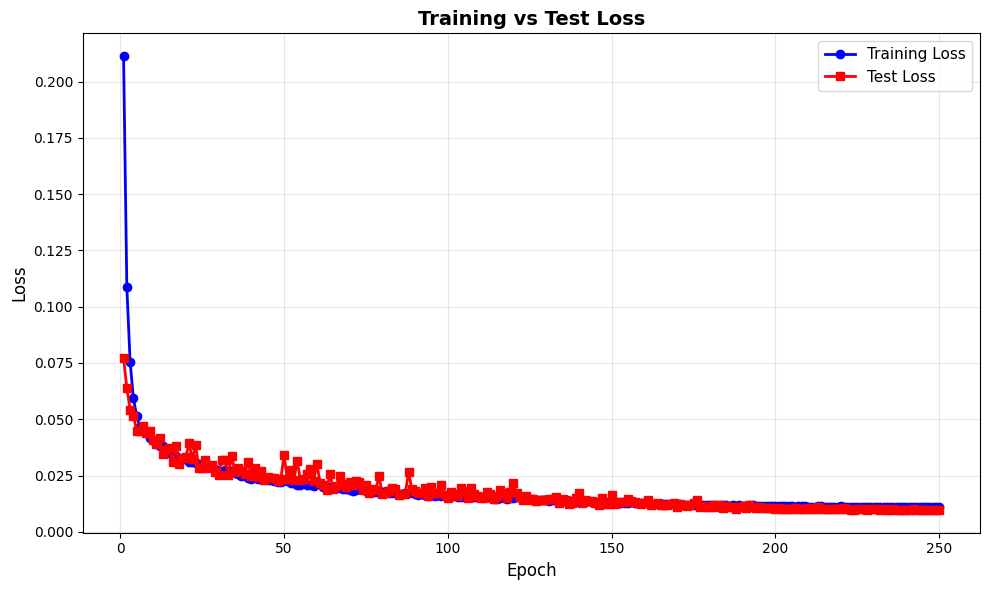

✅ Plot saved: /kaggle/working/POINTNET_20251222_165425/training_loss.png


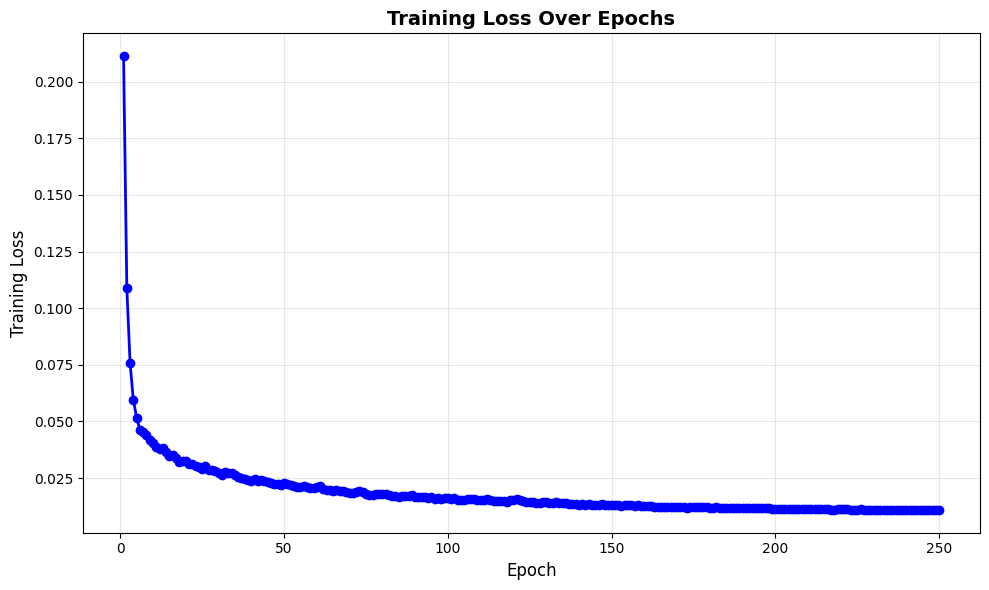

✅ Plot saved: /kaggle/working/POINTNET_20251222_165425/test_loss.png


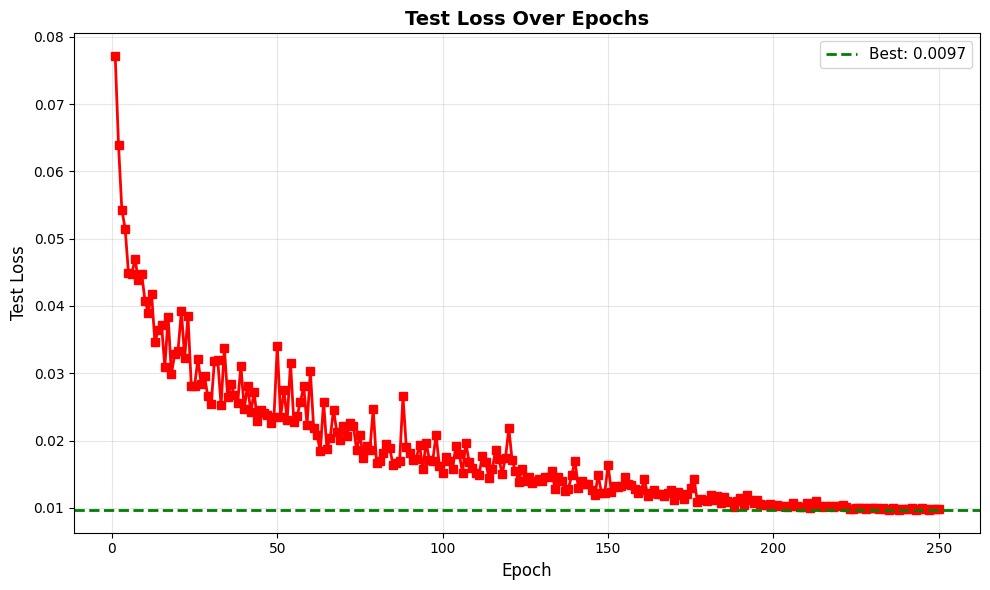


✅ All plots saved in '/kaggle/working/POINTNET_20251222_165425' directory!


In [27]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(test_losses)+1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [29]:
# Save losses
import pickle


losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

In [30]:
sample.keys()

dict_keys(['points', 'centroid', 'rotation', 't_residual', 'gt_translation', 'object_id', 'class_idx', 'img_id', 'cam_K'])

📂 Caricamento checkpoint da: /kaggle/working/POINTNET_20251222_165425/best_model.pth
✅ Modello caricato dall'epoca 243 con loss: 0.0097

📷 Visualizing Sample 1936:
   Object ID: 10
   Image ID: 65

📊 Ground Truth vs Prediction:
   GT Rotation:   [ 0.15214986  0.7251776   0.57534397 -0.3463339 ]
   Pred Rotation: [-0.07677346 -0.7066192  -0.6432206   0.28471458]
   GT Trans (m):   [-0.00122691  0.02205048  0.8281538 ]
   Pred Trans (m): [-0.00107948  0.02190256  0.82867044]
   Translation Error: 0.06 cm


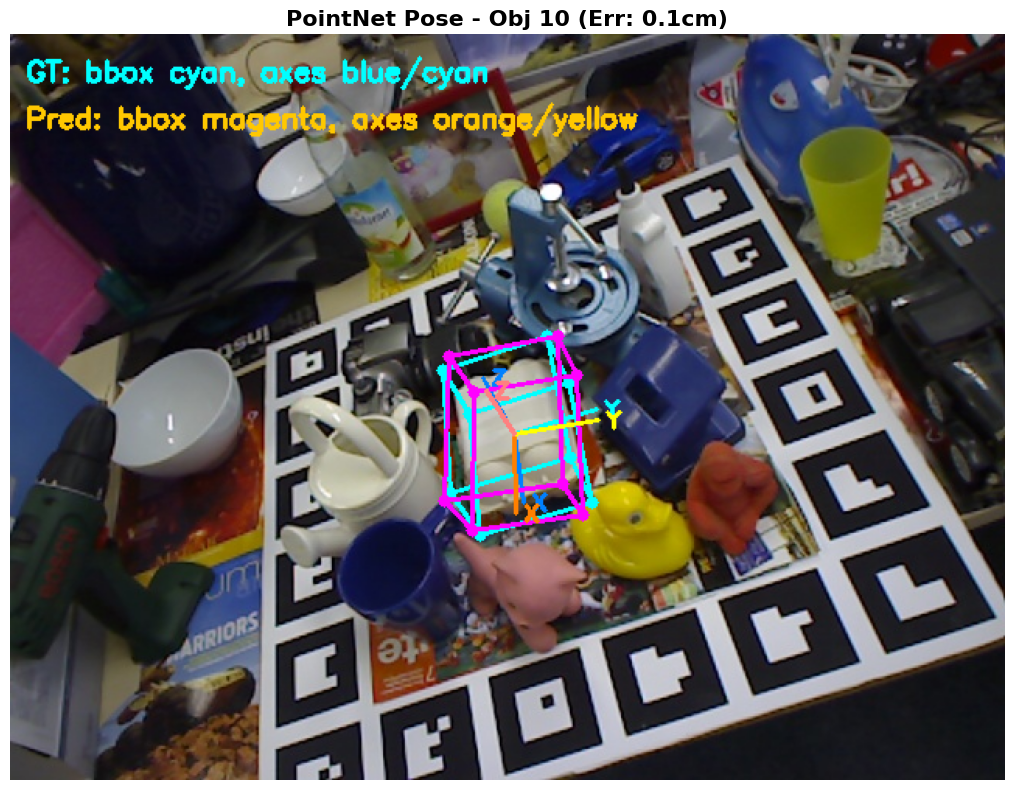


✅ Visualizzazione completata!


In [36]:
import random
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
from utils.projection_utils import setup_projection_utils, visualize_pose_comparison

# ==========================================
# 1. SETUP E CARICAMENTO MODELLO
# ==========================================

# Setup projection utils (assumiamo dataset_root sia definito)
setup_projection_utils(dataset_root)

# Load best model
best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
if not os.path.exists(best_checkpoint_path):
    raise FileNotFoundError(f"Checkpoint non trovato: {best_checkpoint_path}")

print(f"📂 Caricamento checkpoint da: {best_checkpoint_path}")
checkpoint = torch.load(best_checkpoint_path, map_location=device)

state_dict = checkpoint['model_state_dict']

# Rimuovi il prefisso 'module.' se il modello era in DataParallel
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    # name = k[7:] if k.startswith('module.') else k 
    name = "module." + k
    new_state_dict[name] = v

# Inizializza il modello (Assumiamo PointNetPoseModel sia importata)
# model = PointNetPoseModel(num_points=1024).to(device) # Scommenta se devi instanziare
model.load_state_dict(new_state_dict)
model.eval()

print(f"✅ Modello caricato dall'epoca {checkpoint.get('epoch', '?')} con loss: {checkpoint.get('best_val_loss', '?'):.4f}")

# ==========================================
# 2. SELEZIONE E PREPARAZIONE SAMPLE
# ==========================================

# Seleziona un indice casuale dal test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[random_idx]

print(f"\n📷 Visualizing Sample {random_idx}:")
print(f"   Object ID: {sample['object_id']}")
# Gestione robusta nel caso 'img_id' manchi (vecchi dataset)
img_id_display = sample.get('img_id', 'N/A')
print(f"   Image ID: {img_id_display}")

# Recuperiamo l'immagine RGB originale per disegnare sopra
# Nel dataset PointNet non carichiamo l'RGB nel __getitem__, quindi dobbiamo farlo a mano qui
# Costruiamo il path usando le info nel sample o nel config
if 'img_path' in sample:
    img_path = sample['img_path']
else:
    # Fallback: ricostruiamo il path se non è nel sample
    # (Assumendo struttura LineMod standard)
    obj_id = sample['object_id']
    img_id = sample['img_id']
    img_path = os.path.join(dataset_root, 'data', f"{obj_id:02d}", 'rgb', f"{img_id:04d}.png")

image_bgr = cv2.imread(str(img_path))
if image_bgr is None:
    raise FileNotFoundError(f"Impossibile caricare immagine da: {img_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# ==========================================
# 3. INFERENZA POINTNET
# ==========================================

# Prepara i tensori (Aggiungi dimensione batch)
points = sample['points'].unsqueeze(0).to(device)       # (1, 3, N)
centroid = sample['centroid'].unsqueeze(0).to(device)   # (1, 3)

with torch.no_grad():
    # Il modello restituisce rotazione E residuo traslazione
    pred_q, pred_t_res = model(points)
    
    # Ricostruzione Traslazione Assoluta
    # T_abs = Centroid + Residual
    pred_trans_abs = centroid + pred_t_res

# Converti in numpy per visualizzazione
pred_rotation = pred_q[0].cpu().numpy()
pred_translation = pred_trans_abs[0].cpu().numpy()

# Ground Truth
gt_rotation = sample['rotation'].numpy()
gt_translation = sample['gt_translation'].numpy() # O sample['translation']
cam_K = sample['cam_K'].numpy()

print(f"\n📊 Ground Truth vs Prediction:")
print(f"   GT Rotation:   {gt_rotation}")
print(f"   Pred Rotation: {pred_rotation}")
print(f"   GT Trans (m):   {gt_translation}")
print(f"   Pred Trans (m): {pred_translation}")

# Calcola errore distanza (solo per curiosità)
dist_error = np.linalg.norm(gt_translation - pred_translation)
print(f"   Translation Error: {dist_error*100:.2f} cm")

# ==========================================
# 4. VISUALIZZAZIONE
# ==========================================

# Visualizza confronto pose
# Nota: La funzione visualize_pose_comparison si aspetta un'immagine RGB (numpy)
img_vis = visualize_pose_comparison(
    image_rgb,
    object_id=sample['object_id'],
    cam_K=cam_K,
    gt_rotation=gt_rotation,
    gt_translation=gt_translation,
    pred_rotation=pred_rotation,
    pred_translation=pred_translation  # <-- ORA USIAMO LA TRASLAZIONE PREDETTA!
)

# Plot con Matplotlib
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
# visualize_pose_comparison ritorna RGB se gli passi RGB, quindi ok
ax.imshow(img_vis)
ax.axis('off')
ax.set_title(f"PointNet Pose - Obj {sample['object_id']} (Err: {dist_error*100:.1f}cm)", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualizzazione completata!")

In [32]:
import torch
import os

# Definizione percorso
save_path = "pointnet_vanilla_best.pth"

# Gestione DataParallel (se stavi usando 2 GPU)
if isinstance(model, torch.nn.DataParallel):
    state_dict = model.module.state_dict()
else:
    state_dict = model.state_dict()

# Salvataggio
torch.save(state_dict, save_path)

print(f"✅ Modello salvato in: {os.path.abspath(save_path)}")
print("⚠️ ORA SCARICALO SUBITO! Se la sessione cade, il file sparisce.")

checkpoint = {
    'epoch': 30,  # O l'ultima epoca a cui sei arrivato
    'model_state_dict': state_dict, # Usa lo state_dict pulito calcolato sopra
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': 0.0368, # La tua best loss
}

torch.save(checkpoint, "pointnet_checkpoint_full.pth")
print("✅ Checkpoint completo salvato.")

✅ Modello salvato in: /kaggle/working/pointnet_vanilla_best.pth
⚠️ ORA SCARICALO SUBITO! Se la sessione cade, il file sparisce.
✅ Checkpoint completo salvato.


In [33]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 11.2 MB/s eta 0:00:00 0:00:01


In [37]:
import torch
import numpy as np
import os
import trimesh
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
from metrics.ADD_metric import compute_ADD_metric_quaternion, compute_ADDs_metric_quaternion
# Ensure you import the correct PointNet model class here
from src.pose_pointnet.model import PointNetPoseModel 

# ==========================================
# 1. LOAD DATA AND DIAMETERS
# ==========================================
def load_models_info(models_dir, obj_ids, num_points=1000):
    """
    Loads sampled points and calculates the DIAMETER of each object.
    (This function remains unchanged as it works on .ply files).
    """
    point_cache = {}
    diameters = {}
    
    unique_ids = list(set(obj_ids))
    print(f"⏳ Loading info for {len(unique_ids)} models...")
    
    for oid in tqdm(unique_ids, desc="Mesh Analysis"):
        filename = f"obj_{int(oid):02d}.ply"
        path = os.path.join(models_dir, filename)
        
        if os.path.exists(path):
            mesh = trimesh.load(path)
            # 1. Sample points for ADD metric calculation
            points, _ = trimesh.sample.sample_surface(mesh, num_points)
            point_cache[oid] = points / 1000.0  # Convert mm to Meters
            
            # 2. Diameter Calculation (Max distance in the mesh)
            extents = mesh.extents / 1000.0  # Meters
            diameter = np.linalg.norm(extents)
            diameters[oid] = diameter
        else:
            print(f"⚠️ Missing model file: {path}")
            
    return point_cache, diameters

# ==========================================
# 2. COMPREHENSIVE EVALUATION (POINTNET VERSION)
# ==========================================
def evaluate_comprehensive(model, dataloader, device, models_dir, output_csv="evaluation_results.csv"):
    """
    Evaluates the PointNet model using ADD and ADD-S metrics.
    """
    model.eval()
    
    # --- MAPPING ID TO NAMES (LineMOD Standard) ---
    id_to_name = {
        1: 'ape', 2: 'benchvise', 4: 'camera', 5: 'can', 6: 'cat',
        8: 'driller', 9: 'duck', 10: 'eggbox', 11: 'glue',
        12: 'holepuncher', 13: 'iron', 14: 'lamp', 15: 'phone'
    }

    # Define IDs to evaluate
    all_obj_ids = list(id_to_name.keys())
    
    # Load mesh data (Points and Diameters)
    points_dict, diameters_dict = load_models_info(models_dir, all_obj_ids)
    
    # Data Structures for logging
    errors_dict = defaultdict(list)
    accuracy_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    # Objects requiring ADD-S (Symmetric objects)
    SYMMETRIC_OBJECTS = [10, 11]  # Eggbox, Glue
    
    print("\n🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # --- UPDATED INPUTS FOR POINTNET ---
            # We load points and centroids, not images
            points = batch['points'].to(device)           # (B, 3, N)
            centroids = batch['centroid'].to(device)      # (B, 3)
            
            gt_quats = batch['rotation'].to(device)       # (B, 4)
            gt_trans = batch['gt_translation'].to(device) # (B, 3) - Absolute GT
            obj_ids = batch['object_id']
            
            # --- FORWARD PASS ---
            # Predict Rotation and Residual Translation
            pred_quats, pred_t_res = model(points)
            
            # --- RECONSTRUCT ABSOLUTE TRANSLATION ---
            # Abs_Trans = Centroid + Residual
            pred_trans_abs = centroids + pred_t_res
            
            batch_size = points.shape[0]
            for i in range(batch_size):
                curr_id = int(obj_ids[i])
                if curr_id not in points_dict: continue

                # Select Metric: ADD-S for symmetric, ADD for others
                metric = compute_ADDs_metric_quaternion if curr_id in SYMMETRIC_OBJECTS else compute_ADD_metric_quaternion
                
                # --- CALCULATE ERROR ---
                # We pass the PREDICTED translation (pred_trans_abs), not the GT one!
                # This evaluates the full 6D pose (Rot + Trans).
                add_error = metric(
                    model_points=points_dict[curr_id],
                    gt_quat=gt_quats[i].cpu().numpy(),
                    gt_translation=gt_trans[i].cpu().numpy(),
                    pred_quat=pred_quats[i].cpu().numpy(),
                    pred_translation=pred_trans_abs[i].cpu().numpy() 
                )
                
                # Store absolute error
                errors_dict[curr_id].append(add_error)
                
                # Calculate Accuracy (Threshold = 10% of diameter)
                threshold = diameters_dict[curr_id] * 0.1
                accuracy_stats[curr_id]["total"] += 1
                if add_error < threshold:
                    accuracy_stats[curr_id]["correct"] += 1

    # ==========================================
    # 3. PANDAS REPORT GENERATION
    # ==========================================
    results_data = []
    
    total_acc_correct = 0
    total_acc_count = 0
    total_errors = []

    sorted_ids = sorted(errors_dict.keys())
    
    for oid in sorted_ids:
        # Error stats
        mean_err_m = np.mean(errors_dict[oid])
        mean_err_cm = mean_err_m * 100.0
        total_errors.extend(errors_dict[oid])
        
        # Accuracy stats
        stats = accuracy_stats[oid]
        acc_perc = (stats["correct"] / stats["total"]) * 100.0 if stats["total"] > 0 else 0.0
        
        total_acc_correct += stats["correct"]
        total_acc_count += stats["total"]
        
        diam_cm = diameters_dict[oid] * 100.0
        
        # Get Class Name
        class_name = id_to_name.get(oid, "Unknown")

        # Append to list
        results_data.append({
            "Object ID": oid,
            "Class Name": class_name,
            "Diameter (cm)": round(diam_cm, 2),
            "Mean ADD Error (cm)": round(mean_err_cm, 2),
            "Accuracy (%)": round(acc_perc, 2),
            "Samples": stats['total']
        })

    # Create DataFrame
    df = pd.DataFrame(results_data)

    # Calculate Global Stats
    global_mean_error_cm = np.mean(total_errors) * 100.0 if total_errors else 0.0
    global_accuracy = (total_acc_correct / total_acc_count * 100.0) if total_acc_count > 0 else 0.0

    # Add Global Row
    global_row = pd.DataFrame([{
        "Object ID": "GLOBAL",
        "Class Name": "ALL", 
        "Diameter (cm)": "-",
        "Mean ADD Error (cm)": round(global_mean_error_cm, 2),
        "Accuracy (%)": round(global_accuracy, 2),
        "Samples": total_acc_count
    }])
    
    df = pd.concat([df, global_row], ignore_index=True)

    # Print and Save
    print("\n" + "="*80)
    print("FINAL EVALUATION REPORT (POINTNET)")
    print("="*80)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    print(df.to_string(index=False))
    print("="*80)
    
    df.to_csv(output_csv, index=False)
    print(f"✅ Results saved to {output_csv}")

In [38]:
from collections import OrderedDict
# --- USAGE ---

# 1. Define Paths
MODELS_ROOT = "/kaggle/input/line-mode/Linemod_preprocessed/models"
# in case of the samll dataset
# MODELS_ROOT = "/kaggle/input/linemode-preprocessed-small/Linemod_preprocessed_small/models"
checkpoint_path = checkpoint_dir + "/best_model.pth"

# 2. Load Checkpoint
print(f"📂 Loading checkpoint from: {checkpoint_path}")
data = torch.load(checkpoint_path, map_location=device)
state_dict = data['model_state_dict']

# 3. Clean State Dict (Remove 'module.' prefix from DataParallel)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k 
    new_state_dict[name] = v

# 4. Initialize and Load Model
test_model = PointNetPoseModel()
test_model.load_state_dict(new_state_dict)
test_model.to(device)

# 5. Run Evaluation
evaluate_comprehensive(
    test_model, 
    test_loader, 
    device, 
    MODELS_ROOT, 
    output_csv=checkpoint_dir + '/linemod_results.csv'
)

📂 Loading checkpoint from: /kaggle/working/POINTNET_20251222_165425/best_model.pth
⏳ Loading info for 13 models...


Mesh Analysis:   0%|          | 0/13 [00:00<?, ?it/s]


🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


FINAL EVALUATION REPORT (POINTNET)
Object ID  Class Name Diameter (cm)  Mean ADD Error (cm)  Accuracy (%)  Samples
        1         ape         14.21                 0.82         90.32      248
        2   benchvise         33.09                 1.00         97.94      243
        4      camera         22.19                 0.91         98.34      241
        5         can         28.42                 0.94         97.92      240
        6         cat         18.59                 0.66         98.73      236
        8     driller         31.88                 1.08         97.90      238
        9        duck         15.57                 0.84         95.22      251
       10      eggbox          19.7                 0.55        100.00      251
       11        glue         19.31                 0.51        100.00      244
       12 holepuncher         17.38                 0.88         95.56      248
       13        iron         31.72                 7.72         43.72      231
    